In [19]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score,accuracy_score,f1_score
from sklearn.feature_selection import SelectPercentile, f_classif,SelectKBest

In [20]:
# Loading Data
train=pd.read_csv('F:/Analytics/criminal/criminal_train.csv')
test=pd.read_csv('F:/Analytics/criminal/criminal_test.csv')
train.head()

,PERID,IFATHER,NRCH17_2,IRHHSIZ2,IIHHSIZ2,IRKI17_2,IIKI17_2,IRHH65_2,IIHH65_2,PRXRETRY,...,TOOLONG,TROUBUND,PDEN10,COUTYP2,MAIIN102,AIIND102,ANALWT_C,VESTR,VEREP,Criminal
0,25095143,4,2,4,1,3,1,1,1,99,...,1,2,1,1,2,2,3884.805998,40026,1,0
1,13005143,4,1,3,1,2,1,1,1,99,...,2,2,2,3,2,2,1627.108106,40015,2,1
2,67415143,4,1,2,1,2,1,1,1,99,...,2,2,2,3,2,2,4344.957980,40024,1,0
3,70925143,4,0,2,1,1,1,1,1,99,...,2,2,1,1,2,2,792.521931,40027,1,0
4,75235143,1,0,6,1,4,1,1,1,99,...,2,2,2,2,2,2,1518.118526,40001,2,0


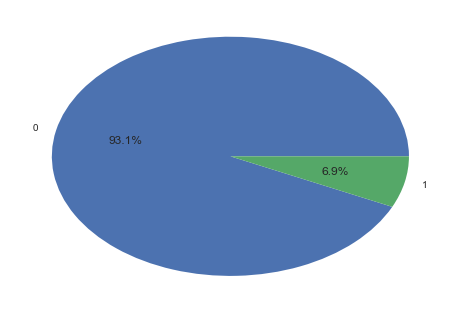

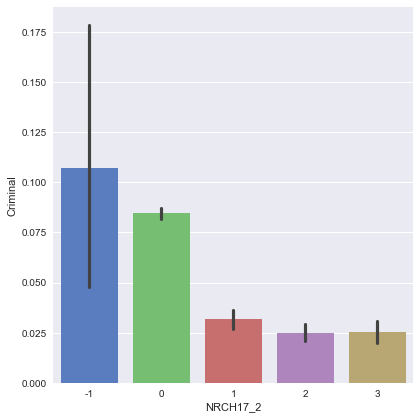

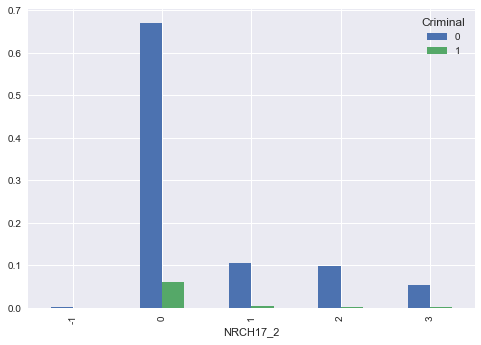

In [21]:
# Plot data
plt.pie(train.Criminal.value_counts()/train.shape[0],labels=[0,1],autopct='%1.1f%%')
sns.factorplot(x="NRCH17_2",y="Criminal",data=train,kind="bar", size = 6 , 
palette = "muted")
c=pd.crosstab(train['NRCH17_2'],train['Criminal'],normalize=True)
c.plot(kind='bar')
plt.show()

In [22]:
unique=train.apply(lambda x:len(x.unique()))
#Merging less frequent Catagorical variables  into one
cat=train.dtypes.loc[train.dtypes=='int64'][1:].index
for b in cat:
    freq=train[b].value_counts()/train.shape[0]
    cat_to_combine=freq.loc[freq.values<.05].index
    for c in cat_to_combine:
        train[b].replace({c:-2},inplace=True)
        test[b].replace({c:-2},inplace=True)

In [23]:
#One hot encoding
no_hot_encode=['PDEN10','POVERTY3','IIPINC3','IRPINC3']
l=[i for i in cat if i not in no_hot_encode]
for i in l:
    P=pd.get_dummies(train[i],drop_first=True,prefix=i)
    train.drop(i,axis=1,inplace=True)
    train=train.join(P,how='right') 
train.head()

,PERID,IRPINC3,IIPINC3,POVERTY3,PDEN10,ANALWT_C,IFATHER_1,IFATHER_2,IFATHER_4,NRCH17_2_0,...,TROUBUND_1,TROUBUND_2,COUTYP2_1,COUTYP2_2,COUTYP2_3,MAIIN102_2,AIIND102_2,VEREP_1,VEREP_2,Criminal_1
0,25095143,1,1,2,1,3884.805998,0,0,1,0,...,0,1,1,0,0,1,1,1,0,0
1,13005143,1,1,1,2,1627.108106,0,0,1,0,...,0,1,0,0,1,1,1,0,1,1
2,67415143,2,1,1,2,4344.957980,0,0,1,0,...,0,1,0,0,1,1,1,1,0,0
3,70925143,7,1,3,1,792.521931,0,0,1,1,...,0,1,1,0,0,1,1,1,0,0
4,75235143,1,1,1,2,1518.118526,1,0,0,1,...,0,1,0,1,0,1,1,0,1,0


In [24]:
#Split dataset
X=train.iloc[:,1:-1].values
y=train.iloc[:,-1].values
x=test.iloc[:,1:]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

In [25]:
# Fit Naive Bayes algorithm
from sklearn.naive_bayes import GaussianNB
clf=GaussianNB()
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

In [26]:
#Fit decision tree algorithm
from sklearn.tree import DecisionTreeClassifier
model_1 = DecisionTreeClassifier(min_samples_split=100,criterion='entropy')
model_1.fit(X_train, y_train)
y_pred1= model_1.predict(X_test)

In [27]:
#Fit Random forest classifier
from sklearn.ensemble import RandomForestClassifier
model_2=RandomForestClassifier(criterion='entropy', min_samples_split= 30, n_estimators= 20)
model_2.fit(X_train,y_train)
y_pred2=model_2.predict(X_test)

In [28]:
#Fit AdaBoostclassifier
from sklearn.ensemble import AdaBoostClassifier
model_3=AdaBoostClassifier(n_estimators=100,learning_rate=.2)
model_3.fit(X_train,y_train)
#Fit Gradient boosting classifier
from sklearn.ensemble import GradientBoostingClassifier
model_4=GradientBoostingClassifier()
model_4.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [29]:
#Ensemble all models using voting classifier
from sklearn.ensemble import VotingClassifier
votingC = VotingClassifier(estimators=[('rfc', model_2),('dct',model_1),('adb',model_3),('grb',model_4)], voting='soft', n_jobs=4)
votingC.fit(X_train,y_train)
y_pred5=votingC.predict(X_test)

In [30]:
# F2 score,accuracy and confusion matrix
z=fbeta_score(y_test,y_pred5,beta=.5)
accuracy=accuracy_score(y_test,y_pred)
from sklearn.metrics import confusion_matrix
cnf_mt=confusion_matrix(y_test,y_pred,labels=[1,0])

In [31]:
z #As positive examples are low so that acccuracy is not best way to measure performance

0.66267942583732065

In [38]:
from sklearn.model_selection import cross_val_score
f1_scores = cross_val_score(estimator = votingC, X = X_train, y = y_train, cv = 5,scoring='f1')
f1_scores.mean()

0.59805146025770495

In [39]:
f1_scores

array([ 0.62483311,  0.58823529,  0.55945946,  0.59893048,  0.61879896])